## Inicjalizacja środowiska programistycznego

In [1]:
#Color printing
from termcolor import colored

#General data operations library
import math
import string
from datetime import datetime
import numpy as np

#The tensorflow library
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "1"
import tensorflow  as tf

#Plotting libraries
import matplotlib as mpl
import matplotlib.pyplot as plt

#Increase plots font size
params = {'legend.fontsize': 'xx-large',
          'figure.figsize': (10, 7),
         'axes.labelsize': 'xx-large',
         'axes.titlesize':'xx-large',
         'xtick.labelsize':'xx-large',
         'ytick.labelsize':'xx-large'}
plt.rcParams.update(params) 

#append path with python modules
import importlib
import sys
sys.path.append("../modules")

#Private functions
import plotting_functions as plf
importlib.reload(plf);

import emnist_functions as emnist_fcn
importlib.reload(emnist_fcn);
#Hide GPU
#tf.config.set_visible_devices([], 'GPU')

<br/><br/>
<br/><br/>

<h1 align="center">
 Uczenie maszynowe II
</h1>

<br/><br/>
<br/><br/>
<br/><br/>
<br/><br/>

<h1 align="right">
Artur Kalinowski <br>
Uniwersytet Warszawski <br>
Wydział Fizyki <br>    
</h1>

# Transponowana warstwa splotowa

Architektury używające warstw splotowych i łączących prowadzą zwykle do redukcji rozmiaru obrazu, ang. `downsampling`,
w kolejnych warstwach sieci. Warstwy, które prowadzą do zwiększenia rozmiaru obrazu to warstwy ekspansji, ang. `upsampling layers`.
Najbardziej popularną warstwą ekspansji jest transponowana warstwa splotowa, ang. `transposed convlolution layer`.


Źródło rysunków: [A guide to convolution arithmetic for deep learning, arXiv:1603.07285](https://arxiv.org/abs/1603.07285)

Standardowa reprezentacja splotu, jako okna z wagami przesuwającego się po obrazie:

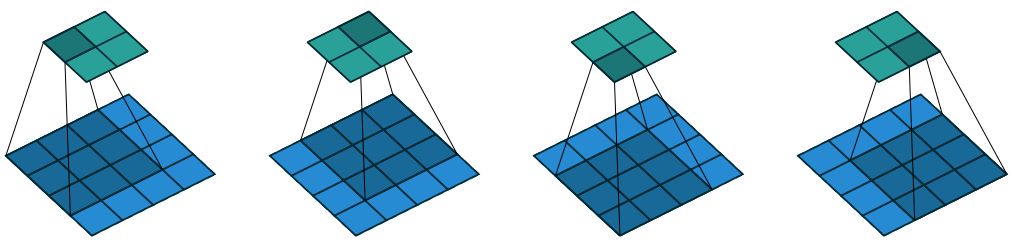

Macierzowa reprezentacja splotu. Obraz wejściowy w tej reprezentacji jest spłaszczony do wektora:

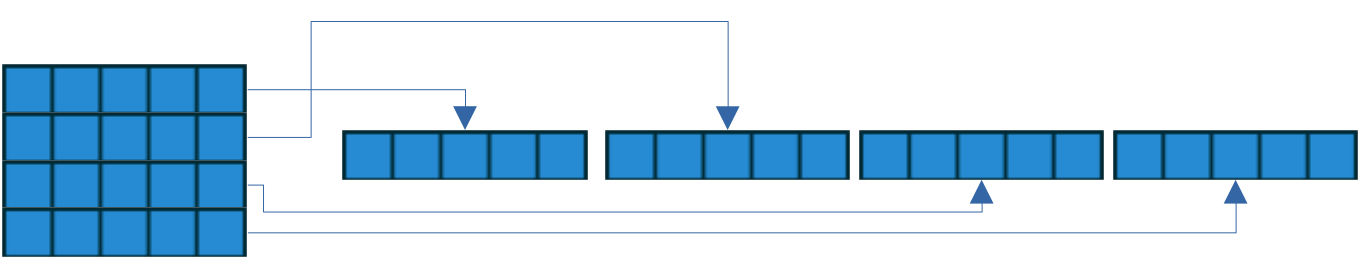

Wędrujące okno może być zastąpione pojedynczą operacją mnożenia macierzy reprezentującej wagi dla wszystkich elementów obrazu.
Dla przykładu powyżej macierz reprezentująca wszystkie wagi splotu ma postać:

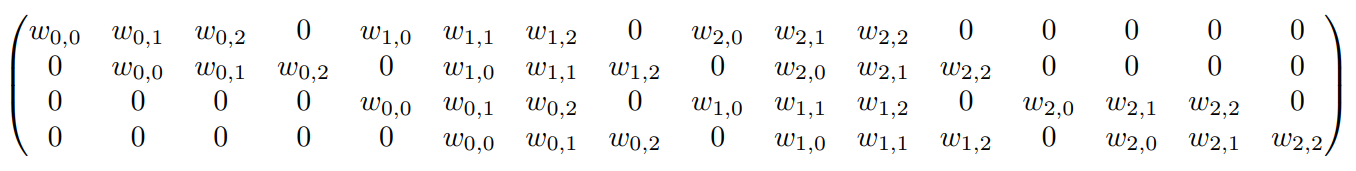

Operacja splotu sprowadza się więc do mnożenia macierzy:

$$
{\huge
r = C \times d
}
$$
**r** - wynik splotu o kształcie (4,1)

**C** - macierz splotu, o kształcie (4,16)

**d** - wektor danych o kształcie (16,1)


Macierz wynikowa w tym przykładzie ma kształt `(4,1)` i można ją zamienić na macierz o kształcie `(2,2)`, takim jakiego oczekujuemy dla
wyniku splotu w tym przykładzie.

Macierz $C^{T}$ możemy traktować jako macierz operacji transpozycji która przeprowadza wektory o kształcie `(4,1)` w wektory o kształcie `(16,1)` 

$$
{\huge
r' = C^{T} \times r
}
$$
**r'** - wynik splotu o kształcie (16,1)

$\mathbf{C^{T}}$ - macierz splotu o kształcie (4,16)

**r** - wektor danych o kształcie (4,1)

W ten sposób uzyskaliśmy skalowanie w górę - z wektora o rozmiarze `(4,1)` uzyskaliśmy wektor o rozmiarze `(16,1)`

**Uwaga:** transponowany splot nie odtwarza oryginalnej macierzy danych, ponieważ w ogólności


$$
{\huge
C^{T} \cdot C \neq 1_{16 \times 16}
}
$$
**Po operacji splotu transponowanego odzyskujemy jedynie oryginalny kształt.**

Splot transponowany może być też reprezentowany jako standardowy splot z odpowiednim wypełnianiem zerami.

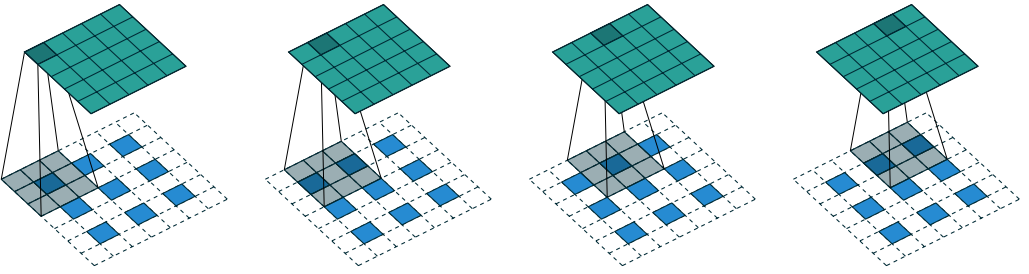

Interfejs użytkownika warstwy konwolucyjnej w Keras:
```Python
tf.keras.layers.Conv2DTranspose(
    filters,             # liczba filtrów
    kernel_size,         # rozmiar filtra: krotka (n,m), lub (n) dla filtrów kwadratowych
    strides=(1, 1),      # wartość kroku w obu wymiarach
    padding='valid',     # sposób dopełnienia: 
                         # `valid` - brak dopełnienia
                         # `same` - dopełnienie zerami na brzegach, w rozmiarze połowy
                         # dopełnienie wynosi połowę rozmiaru filtra w odpowiednim kierunku
    output_padding=None, # dopełnienie na brzegach wynikowego obrazu
)
```

 **Proszę**:

* zbudować warstwę transponowaną splotową z jednym filtrem o rozmiarze `(3,3)` i pozostałych parametrach z domyślnymi wartościami
* podać na jej wejściu rysunek o rozmiarze `(2,2)` wypełniony jedynkami
* wypisać na ekran kształt wejścia i wyjścia warstwy

In [ ]:
#BEGIN_SOLUTION
layer = tf.keras.layers.Conv2DTranspose(filters = 1, kernel_size=(3,3))
data = np.full((1,2,2, 1), 1.0)

print(colored("Input shape:","blue"),data.shape)
print(colored("Output shape:","blue"),layer(data).shape)
#END_SOLUTION
pass

 **Proszę**:

* zbudować warstwę transponowaną splotową z filtrami o rozmiarze `(3,3)` i pozostałych parametrami tak dobranymi, by uzyskać
  transformację obrazu `(2,2,1)` na `(8,8,3)`, gdzie ostatnia wartość oznacza liczbę kanałów
* wypisać na ekran kształt wejścia i wyjścia warstwy

**Wskazówka:** proszę zajrzeć do dokumentacji [tf.keras.layers.Conv2DTranspose](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv2DTranspose), by sprawdzić wzór na rozmiar wyniku warstwy Conv2DTranspose.

In [ ]:
#BEGIN_SOLUTION
layer = tf.keras.layers.Conv2DTranspose(filters = 2, kernel_size=(3,3), strides=4, padding='same')
data = np.full((1,2,2, 1), 1.0)

print(colored("Input shape:","blue"),data.shape)
print(colored("Output shape:","blue"),layer(data).shape)

#END_SOLUTION
pass

Standardowe parametry zwiększające rozmiar danych o czynnik dwa to:

```Python
tf.keras.layers.Conv2DTranspose(strides=2, padding='same')
```

### Zagadnienie: sieć, która może generować obrazy okręgów z danych wejściowych w postaci trójki:

$$
\Large{(x, y, R)}
$$ 

* obrazy wyjściowe powinny mieć rozdzielczość 16$\times$16
* środki okręgów powinny się zawierać w płaszczyźnie docelowego obrazu
* dane do treningu będą pochodziły z losowo generowanych okręgów
* rozważymy dwie architektury: w pełni połączoną i splotową

**Proszę:**

* napisać funkcję `discGenerator(res=16)` która będzie generowała pary `(features, label)` parametrów - `features` i obrazów okręgów - `labels` o rozdzielczości $res \times res$
* parametry okręgów powinny być losowe:
    * współrzędne środka w zakresie `[0,res]`
    * promień w zakresie `[0,res/2]`
* kod powinien używać funkcji a pakietu TensorFlow, np. `tf.random.uniform` wszędzie gdzie to możliwe
* okręgi można generować z użyciem funkcji `skimage.draw.disk` (co niestety łamie wymaganie używania jedynie funkcji pakietu TensorFlow)
* funkcja powinna zwracać wartości z użyciem słowa kluczowego `yield` (taka funkcja jest [generatorem](https://book.pythontips.com/en/latest/generators.html)):
```Python

def discGenerator(res=16):
    ...
    yield  features, label
```
* funkcja może być sprawdzona w następujący sposób:
```Python

x = next(discGenerator())
print(colored("Features shape:","blue"), x[0].shape)
print(colored("Labels shape:","blue"), x[1].shape)
```

**Uwaga:** 
* parametr `res` musi mieć wartość domyślną

In [ ]:
def discGenerator(res=16):
#BEGIN_SOLUTION
    from skimage.draw import disk
    while True:
        center = tf.random.uniform([2], minval=0, maxval = res, dtype=tf.int32, name='center')
        radius = tf.random.uniform([1], minval=5, maxval = res//2, dtype=tf.int32, name='radius')        
        shape = (res, res)
        image = np.full(shape, 0)
        yy, xx = disk(center=center.numpy(), radius=radius.numpy()[0], shape=shape)
        image[xx,yy] = 1
        features = tf.concat(values=(center, radius), axis=0 )
        label = tf.constant(image, dtype=tf.int32, name='image')
        label = tf.reshape(label, (res, res, 1))
        yield  features, label
#END_SOLUTION
x = next(discGenerator())
print(colored("Features shape:","blue"), x[0].shape)
print(colored("Labels shape:","blue"), x[1].shape)

**Proszę**:
* stworzyć macierze cech i etykiet:
```Python
features = []
labels = []
```
i wypełnić je 1024 przykładami wygenerowanymi przez generator `discGenerator()`

* wpisać na ekran kształty cech i etykiet

In [ ]:
features = []
labels = []
res = 16
#BEGIN_SOLUTION
for index, item in enumerate(discGenerator(res)):
    if index==1024:
        break
        
    features.append(item[0])
    labels.append(item[1])

features = np.array(features).reshape(-1,3)
labels = np.array(labels).reshape(-1,res,res,1)

print(colored("Features shape:","blue"),features.shape)
print(colored("Labels shape:","blue"),labels.shape)
#END_SOLUTION
pass

**Proszę:** 

* zdefiniować sieć w pełni połączoną: `model_fc` która może generować obrazy okręgów.
* sieć powinna mieć odpowiednie kształty wejścia i wyjścia
* wystarczy by sieć miałą trzy warstwy ukryte
* wartości wyjściowych pikseli powinny się zawierać w zakresie `[0,1]`
* wypisać na ekran podsumowanie modelu

In [ ]:
##BEGIN_SOLUTION
model_fc = tf.keras.Sequential(layers = [tf.keras.Input(shape=(3,)),
                                      ##
                                       tf.keras.layers.Dense(16, activation='relu', 
                                          bias_initializer=tf.keras.initializers.RandomUniform(minval=-1, maxval=1),
                                          kernel_initializer="HeNormal"),
                                       tf.keras.layers.Dense(128, activation='relu', 
                                          bias_initializer=tf.keras.initializers.RandomUniform(minval=-1, maxval=1),
                                          kernel_initializer="HeNormal"),
                                       tf.keras.layers.Dense(256, activation='sigmoid', 
                                          bias_initializer=tf.keras.initializers.RandomUniform(minval=-1, maxval=1),
                                          kernel_initializer="HeNormal"),
                                      tf.keras.layers.Reshape((16,16,1)),                                                                
                                      ##
                                     ],
                                     name="FC_disc_generator")
model_fc.summary()
#END_SOLUTION
pass

**Proszę:**
* zdefiniować sieć `model_cnn` z transponowanymi warstwami splotowymi: `model_cnn` która realizuje to samo zadani co sieć z poprzedniej komórki
* wypisać na ekran podsumowanie modelu

**Wskazówka:** w przypadku sieci splotowej można użyć jednej warstwy gęstej do zwiększenia rozmiaru początkowego obrazu:
```Python

  tf.keras.layers.Dense(4, activation='relu', 
                        bias_initializer=tf.keras.initializers.RandomUniform(minval=-1, maxval=1),
                        kernel_initializer="HeNormal"),
  tf.keras.layers.Reshape((2,2,1)),
```

In [ ]:
#BEGIN_SOLUTION
model_cnn = tf.keras.Sequential(layers = [tf.keras.Input(shape=(3,)),
                                      ##
                                       tf.keras.layers.Dense(4, activation='relu', 
                                          bias_initializer=tf.keras.initializers.RandomUniform(minval=-1, maxval=1),
                                          kernel_initializer="HeNormal"),
                                      tf.keras.layers.Reshape((2,2,1)), 
                                      tf.keras.layers.Conv2DTranspose(filters=64, kernel_size=4, strides=2, padding='same', 
                                                                      activation='relu',
                                                                      bias_initializer=tf.keras.initializers.RandomUniform(minval=-1, maxval=1),
                                                                      kernel_initializer="HeNormal",
                                                                     ),  
                                      tf.keras.layers.Conv2DTranspose(filters=32, kernel_size=3, strides=2, padding='same', 
                                                                      activation='relu',
                                                                      bias_initializer=tf.keras.initializers.RandomUniform(minval=-1, maxval=1),
                                                                      kernel_initializer="HeNormal",
                                                                     ), 
                                       tf.keras.layers.Conv2DTranspose(filters=32, kernel_size=3, strides=2, padding='same', 
                                                                      activation='relu',
                                                                      bias_initializer=tf.keras.initializers.RandomUniform(minval=-1, maxval=1),
                                                                      kernel_initializer="HeNormal",
                                                                     ),   
                                      tf.keras.layers.Conv2D(filters = 1, kernel_size=1, strides=1, padding='same', activation='sigmoid')                                                                   
                                      ##
                                     ],
                                     name="CNN_disc_generator")
model_cnn.summary()
#END_SOLUTION
pass

**Proszę:**

* przeprowadzić trening sieci `model_fc` na `500` epokach z rozmiarem paczki ustawionym na `32`
* narysować zmianę funkcji straty w funkcji numeru epoki na zbiorze treningowym i walidacyjnym
* jako zbioru walidacyjnego użyć `10%` zbioru podanego jako treningowy
* kod trenujący powinien być zawarty w funkcji `trainModel(model, nEpochs)` i zawierać:
    * harmonogram zmiany współczynika uczenia
    * wywołanie wczesnego zatrzymania (sprawdzić wyniki bez zatrzymania)
    * rysowane historii funkcji straty
    * jako funkcji straty proszę użyć entropii krzyżowej: `binary_crossentropy` - każdy z pikseli należy do jednej z dwu klas: `biały/czarny`
* wypisać na ekran wartość funkcji straty wytrenowanego modelu na zbiorze treningowym

In [ ]:
%%time
#BEGIN_SOLUTION
def trainModel(model, nEpochs):
   
    initial_learning_rate = 1E-3
    batchSize = 32
      
    nStepsPerEpoch = int(len(labels)/batchSize)
    lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(initial_learning_rate,
                    decay_steps=nStepsPerEpoch*10,
                    decay_rate=0.95,
                    staircase=False)

    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule), 
                loss='binary_crossentropy', metrics=[])
    
    #run training
    early_stop_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', 
                                                           patience=15, verbose=1)
    callbacks = [early_stop_callback]
    callbacks = []
    
    history = model.fit(x=features, y=labels,
                        epochs=nEpochs, 
                        callbacks=callbacks,
                        validation_split = 0.1,
                        verbose=0)
    
    plf.plotTrainHistory(history)
    print(colored("Evaluation on training dataset:","blue"))
    model.evaluate(features, labels)
#END_SOLUTION   
nEpochs = 500
trainModel(model_fc, nEpochs)

**Proszę:**

* napisać funkcję `plotGenerated(model, params)`, która rysuje panel z czterema obrazy wygenerowanymi przez sieć
  dla zadanego parametrów
* rysunki powinny zawierać okręgi narysowane z nominalnymi wartościami parametrów
* wywołać funkcję `plotGenerated(model, params)` dla modelu `model_fc` i parametrów:
$$
\Large{(x, y, R)} = (0,0,10), (16,0,10), (8,8,5), (8,8,1)
$$

In [ ]:
#BEGIN_SOLUTION
def plotGenerated(model, params):
   
    fig, axes = plt.subplots(2, 2, figsize=(5,5))
    
    for index, axis in enumerate(axes.flat):
        features = tf.Variable([params[index]], dtype=tf.int16)
        image = model(features)[0]
        axis.imshow(image, cmap='binary', origin='lower')
        axis.set_title(str(params[index])); 
        ##
        x = np.linspace(-params[index][2], params[index][2], 10)
        y = np.sqrt(params[index][2]**2-x**2)
        y = np.concatenate((y,-y), axis=0)
        x = np.concatenate((x,x), axis=0)
        x += params[index][0]
        y += params[index][1]
        axis.plot(x,y, "p", markersize=1)
        axis.set_xlim(0,image.shape[0])
        axis.set_ylim(0,image.shape[1])
    plt.subplots_adjust(bottom=0.02, left=0.02, right=0.98, wspace=0.4, hspace=0.4)
#END_SOLUTION

params = np.array( [(0,0,10), (16,0,10), (8,8,5), (8,8,1)] )
plotGenerated(model_fc, params)

**Proszę:**

* przeprowadzić trening sieci `model_cnn` z tymi samymi ustawieniami co dla sieci `model_dnn`
* narysować wygenerowane obrazy dla tych samych parametrów, co w przypadku sieci w pełni połączonej


In [ ]:
%%time
#BEGIN_SOLUTION
trainModel(model_cnn, nEpochs)

params = np.array( [(0,0,10), (16,0,10), (8,8,5), (8,8,1)] )
plotGenerated(model_cnn, params)
#END_SOLUTION
pass

# Architektura autokodera

Sieć ze splotem nie trenuje się zbyt dobrze. Powodem może być niewłaściwa reprezentacja okręgu przez trzy liczby: `(x,y,R)`.
Może istnieje jakaś reprezentacja, która będzie szybciej prowadziła do uzyskania dobrego modelu?

Zamiast samodzielnie eksperymentować z różnymi reprezentacjami skonstruujemy sieć, która znajdzie go sama - **autokoder**, ang. `autoencoder, AE`.

Architektura AE składa się z dwu części:

**sieci kodującej** - sieci która z danych wejściowych tworzy reprezentację o zadanym rozmiarze. Przestrzeń do której prowadzi sieć kodująca jest nazywana przestrzenią ukrytą, ang. `hidden space` lub `bottleneck` - ponieważ to jest miejsce gdzie liczba parametrów opisujących zagadnienie jest zwykle najmniejsza.

**sieci dekodującej** - sieci która z reprezentacji w przestrzeni ukrytej odtwarza oryginalną postać danych wejściowych

W czasie treningu obrazy z dekodera są porównywane z danymi wejściowymi. Wagi są zmieniane tak, by minimalizować różnicę między nimi.

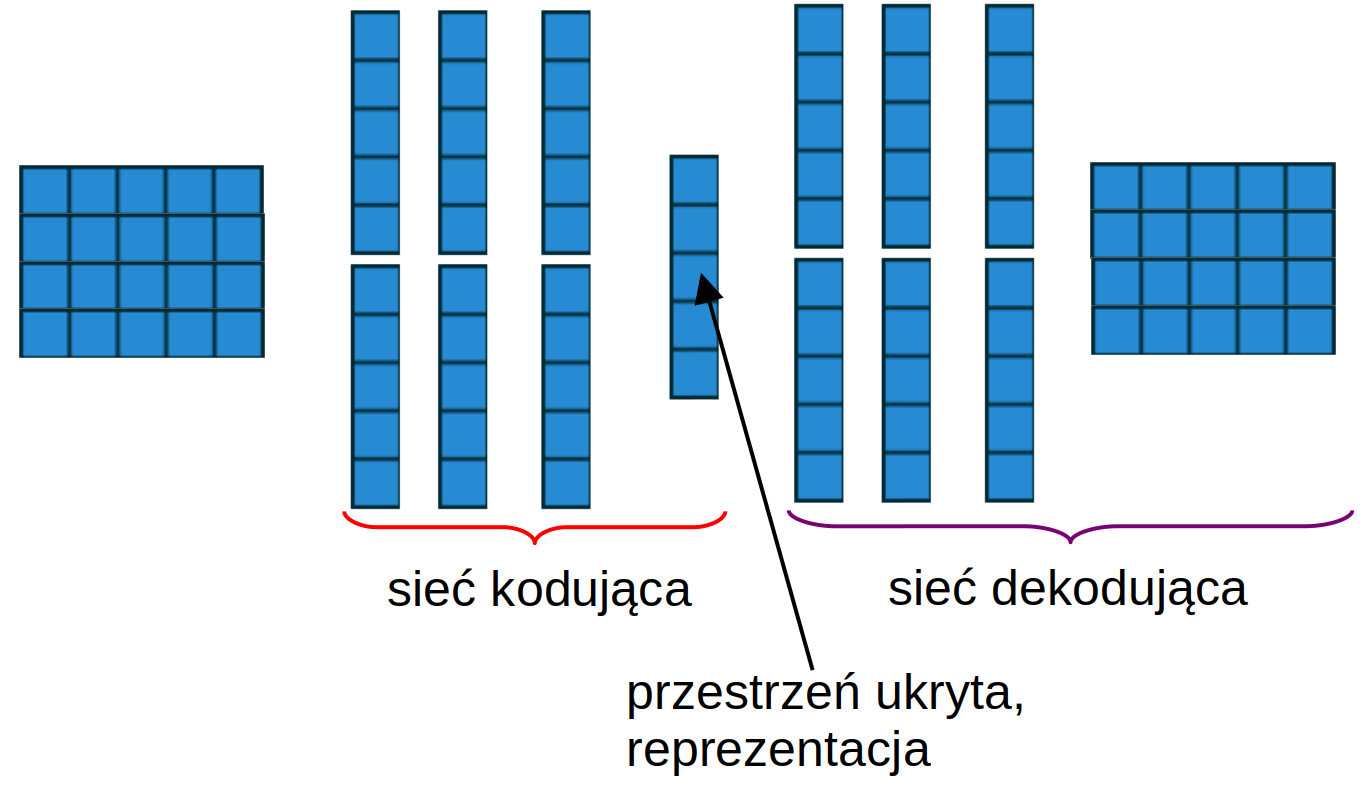

**Proszę:**

* stworzyć model `encoder` - konwolucyjną sieć kodującą wykonującą operację kodowana, czyli zmiany kształtu danych
$$
\Large{    
(16,16,1) \rightarrow (2,2,1)
}
$$
* proszę użyć klasy `tf.keras.Sequential`
* proszę wypisać na ekran podsumowanie modelu

In [ ]:
#BEGIN_SOLUTION
encoder = tf.keras.Sequential(layers = [tf.keras.Input(shape=(16,16,1)),
                                        tf.keras.layers.Conv2D(filters=32, kernel_size=3, strides=2, padding='same', activation='relu'),
                                        tf.keras.layers.MaxPooling2D((2, 2), padding='same'),
                                        tf.keras.layers.Conv2D(filters=32, kernel_size=3, strides=2, padding='same', activation='relu'),
                                        tf.keras.layers.Conv2D(filters=1, kernel_size=2, strides=1, padding='same', activation='relu')],
                                         name='encoder')
encoder.summary()
#END_SOLUTION
pass

**Proszę:**

* stworzyć model `decoder` - sieć dekodującą wykonującą operację odkodowana, czyli zmiany kształtu danych
$$
\Large{    
(2,2,1) \rightarrow (16,16,1)
}
$$
* proszę użyć klasy `tf.keras.Sequential`
* proszę użyć transponowanych splotowych warstw z tymi samymi ustawieniami jak w sieci kodującej
* proszę wypisać na ekran podsumowanie modelu

In [ ]:
#BEGIN_SOLUTION
decoder =  tf.keras.Sequential(layers = [tf.keras.Input(shape=(2,2,1)),
                                         tf.keras.layers.Conv2DTranspose(filters=32, kernel_size=3, strides=2, padding='same', activation='relu'),
                                         tf.keras.layers.Conv2DTranspose(filters=32, kernel_size=3, strides=2, padding='same', activation='relu'),
                                         tf.keras.layers.Conv2DTranspose(filters=32, kernel_size=3, strides=2, padding='same', activation='relu'), 
                                         tf.keras.layers.Conv2D(filters=1, kernel_size=2, strides=1, padding='same', activation='sigmoid')],
                                name="decoder")
decoder.summary()
#END_SOLUTION
pass

**Proszę:**

* utworzyć  `model_cnn_ae` - autokoder -  sieć sekwencyjną która składa się z sieci kodującej, i dekodującej:
```Python

[encoder, decoder]

```
* wywołać model na jednym przykładzie korzystając z funkcji `predict`
```Python

model_cnn_ae.predict(...)
```
* wypisać na ekran podsumowanie modelu

**Uwaga:**
* model przyjmuje paczki, więc dane wejściowe muszą mieć odpowiedni wymiar, nawet jeśli podajemy pojedynczy przykład
* co jest teraz danymi wejściowymi do modelu?

In [ ]:
#BEGIN_SOLUTION
model_cnn_ae = tf.keras.Sequential([encoder, decoder], name="autoencoder")
model_cnn_ae.predict(labels[:1])
model_cnn_ae.summary()
#END_SOLUTION
pass

**Proszę:**

* przeprowadzić trening autokodera
* użyć ustawień treningu jak dla poprzednich modeli

In [ ]:
%%time
#BEGIN_SOLUTION
initial_learning_rate = 1E-3
batchSize = 32
    
nStepsPerEpoch = int(len(labels)/batchSize)
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(initial_learning_rate,
                decay_steps=nStepsPerEpoch*10,
                decay_rate=0.95,
                staircase=False)

model = model_cnn_ae
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule), 
              loss='binary_crossentropy')
    
#run training
history = model.fit(x=labels, y=labels,
                        epochs=nEpochs, 
                        validation_split = 0.1,
                        verbose=0)

model.evaluate(labels, labels)    
plf.plotTrainHistory(history)
#END_SOLUTION
pass

**Proszę:**

* wypisać na ekran parametry pierwszego przykładu ze zbioru danych
* uruchomić koder na obrazie z pierwszego przykładu
* wypisać na ekran zakodowaną postać obrazu

In [ ]:
#BEGIN_SOLUTION
index = 0
print(colored("Human readable disc representation:","blue"), features[index])
z = encoder.predict(labels[index:index+1])
print(colored("AI readable disc representation:","blue"), z)
#END_SOLUTION
pass

**Proszę:**

* napisać funkcję `plotDecoded(model)` która rysuje rysunki uzyskane z modelu `model_cnn_ae` dla czterech losowych przykładów z danych treningowych:
    * parametry z przykładów treningowych są kodowane przez `encoder`
    * zakodowane parametry są odkodowywane przez `decoder`
* rysunki powinny być podpisane wartościami parametrów
* rysunki powinny zawierać okręgi narysowane z nominalnymi wartościami parametrów

In [ ]:
#BEGIN_SOLUTION
def plotDecoded(model):
   
    fig, axes = plt.subplots(2, 2, figsize=(5,5))

    #data_indices = tf.random.uniform([4], 0, len(labels), dtype=tf.int32)
    data_indices = np.array([0,1,2,3])
    for index, axis in enumerate(axes.flat):
        
        data_index = data_indices[index]
        encoded = labels[data_index:data_index+1]

        model.evaluate(encoded,encoded)
        
        z = encoder.predict(encoded, verbose=0)
        image = decoder.predict(z, verbose=0)[0,:,:,0]
        axis.imshow(image, cmap='binary', origin='lower')
        axis.set_title(str(features[data_index]));
        ##
        x = np.linspace(-features[data_index][2], features[data_index][2], 20)
        y = np.sqrt(features[data_index][2]**2-x**2)
        y = np.concatenate((y,-y), axis=0)
        x = np.concatenate((x,x), axis=0)
        y += features[data_index][1]
        x += features[data_index][0]
        axis.plot(x,y, "p", markersize=1) 
        axis.set_xlim([0, image.shape[0]])
        axis.set_ylim([0, image.shape[1]])
        
    plt.subplots_adjust(bottom=0.02, left=0.02, right=0.98, wspace=0.4, hspace=0.4)

#END_SOLUTION
plotDecoded(model_cnn_ae)

# Zadanie domowe

Skonstruować sieć, która będzie generowała obrazy okręgów o rozdzielczości `(256, 256)`.


**Proszę:**

* wygenerować 1024 przykłady obrazów okręgów o rozdzielczości `(256,256)` o losowych parametrach:
    * współrzędne środka w zakresie [0,N]
    * promień w zakresie [0,N/2]
     
* skonstruować **sieć w pełni połączoną** generującą obrazy z trójki:
$$
\Large{(x, y, R)}
$$

* skonstruować **sieć autokodującą** z wymiarem ukrytym o kształcie `(8,8,1)`
* przeprowadzić trening obu sieci 
* narysować obrazy dla czterepch pierwszych przykładów ze zbioru treningowego
* zwrócić uwagę na rozmiar modeli

In [ ]:
##Data generation
#BEGIN_SOLUTION
res = 256
def discGenerator():

    from skimage.draw import disk
    while True:
        center = tf.random.uniform([2], minval=0, maxval = res, dtype=tf.int32, name='center')
        radius = tf.random.uniform([1], minval=5, maxval = res//2, dtype=tf.int32, name='radius')        
        shape = (res, res)
        image = np.full(shape, 0)
        yy, xx = disk(center=center.numpy(), radius=radius.numpy()[0], shape=shape)
        image[xx,yy] = 1
        features = tf.concat(values=(center, radius), axis=0 )
        label = tf.constant(image, dtype=tf.int32, name='image')
        label = tf.reshape(label, (res, res, 1))
        yield  features, label

features = []
labels = []

for index, item in enumerate(discGenerator()):
    if index==1024:
        break
        
    features.append(item[0])
    labels.append(item[1])

features = np.array(features).reshape(-1,3)
labels = np.array(labels).reshape(-1,res,res,1)
#END_SOLUTION
print(colored("Features shape:","blue"),features.shape)
print(colored("Labels shape:","blue"),labels.shape)

In [ ]:
%%time
## autoencoder model
#BEGIN_SOLUTION

#Model definition
encoder = tf.keras.Sequential(layers = [tf.keras.Input(shape=(256,256,1)),
                                        tf.keras.layers.Conv2D(filters=32, kernel_size=3, strides=2, padding='same', activation='relu'),
                                        tf.keras.layers.MaxPooling2D((2, 2), padding='same'),
                                        tf.keras.layers.Conv2D(filters=32, kernel_size=3, strides=2, padding='same', activation='relu'),
                                        tf.keras.layers.MaxPooling2D((2, 2), padding='same'),
                                        tf.keras.layers.Conv2D(filters=32, kernel_size=3, strides=2, padding='same', activation='relu'),
                                        tf.keras.layers.MaxPooling2D((2, 2), padding='same'),
                                        tf.keras.layers.Conv2D(filters=1, kernel_size=2, strides=1, padding='same', activation='relu')],
                                         name='encoder')
encoder.summary()

decoder =  tf.keras.Sequential(layers = [tf.keras.Input(shape=(4,4,1)),
                                         tf.keras.layers.Conv2DTranspose(filters=32, kernel_size=3, strides=2, padding='same', activation='relu'),
                                         tf.keras.layers.Conv2DTranspose(filters=32, kernel_size=3, strides=2, padding='same', activation='relu'),
                                         tf.keras.layers.Conv2DTranspose(filters=32, kernel_size=3, strides=2, padding='same', activation='relu'),
                                         tf.keras.layers.Conv2DTranspose(filters=32, kernel_size=3, strides=2, padding='same', activation='relu'),
                                         tf.keras.layers.Conv2DTranspose(filters=32, kernel_size=3, strides=2, padding='same', activation='relu'),
                                         tf.keras.layers.Conv2DTranspose(filters=32, kernel_size=3, strides=2, padding='same', activation='relu'),
                                         tf.keras.layers.Conv2D(filters=1, kernel_size=2, strides=1, padding='same', activation='sigmoid')],
                                name="decoder")
decoder.summary()

model_cnn_ae = tf.keras.Sequential([encoder, decoder], name="autoencoder")
model_cnn_ae.predict(labels[:1])
model_cnn_ae.summary()

###Training
nEpochs = 200
initial_learning_rate = 1E-3
batchSize = 32
    
nStepsPerEpoch = int(len(labels)/batchSize)
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(initial_learning_rate,
                decay_steps=nStepsPerEpoch*10,
                decay_rate=0.95,
                staircase=False)

model = model_cnn_ae
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule), 
              loss='binary_crossentropy')
    
#run training
history = model.fit(x=labels, y=labels,
                        epochs=nEpochs, 
                        validation_split = 0.1,
                        verbose=0)
    
plf.plotTrainHistory(history)
#END_SOLUTION
#Evaluation
plotDecoded(model_cnn_ae)

In [ ]:
%%time
##fully connected model
#BEGIN_SOLUTION
#model definition
model_fc = tf.keras.Sequential(layers = [tf.keras.Input(shape=(3,)),
                                      ##
                                       tf.keras.layers.Dense(16, activation='relu', 
                                          bias_initializer=tf.keras.initializers.RandomUniform(minval=-1, maxval=1),
                                          kernel_initializer="HeNormal"),
                                       tf.keras.layers.Dense(128, activation='relu', 
                                          bias_initializer=tf.keras.initializers.RandomUniform(minval=-1, maxval=1),
                                          kernel_initializer="HeNormal"),
                                       tf.keras.layers.Dense(256*256, activation='sigmoid', 
                                          bias_initializer=tf.keras.initializers.RandomUniform(minval=-1, maxval=1),
                                          kernel_initializer="HeNormal"),
                                      tf.keras.layers.Reshape((256,256,1)),                                                                
                                      ##
                                     ],
                                     name="FC_disc_generator")
model_fc.summary()


#model training
trainModel(model_fc, nEpochs)

#END_SOLUTION
#model evaluation
params = features[0:4]
plotGenerated(model_fc, params)